# Prediction of student academic performance and evaluation of educational intervention strategies based on supervised learning

This is the code part of the project. I'm gonna finish the whole project step by step.


### Importing Libraries

In [173]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay


import tensorflow as tf
import keras
from keras.layers import Dense, Input, Layer
from keras.models import Model, Sequential
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt

### Read the Dataset

In [2]:
Raw_Assessments = pd.read_csv('DataSet_OULAD/Assessments.csv')
Raw_Courses = pd.read_csv('DataSet_OULAD/Courses.csv')
Raw_Vle = pd.read_csv('DataSet_OULAD/Vle.csv')
Raw_StudentAssessment = pd.read_csv('DataSet_OULAD/StudentAssessment.csv')
Raw_StudentInfo = pd.read_csv('DataSet_OULAD/StudentInfo.csv')
Raw_StudentRegistration = pd.read_csv('DataSet_OULAD/StudentRegistration.csv')
Raw_StudentVle = pd.read_csv('DataSet_OULAD/StudentVle.csv')

### Data Preprocessing

#### Set mysql ready

In [3]:
mysql_config = {
    "host": "localhost",
    "port": 3306,
    "user": "root",
    "password": "mis+underStoo9d",
    "database": "EDUC7041_Project",
    "charset": "utf8mb4"
}

# create SQLAlchemy engine
engine = create_engine(
    f"mysql+mysqlconnector://{mysql_config['user']}:{mysql_config['password']}@{mysql_config['host']}:{mysql_config['port']}/{mysql_config['database']}"
)

#### Back up raw dataset
Back up the raw dataset in case of any data loss.

In [4]:
Assessments = Raw_Assessments.copy(deep=True)
Courses = Raw_Courses.copy(deep=True)
#Vle = Raw_Vle.copy(deep=True)
StudentAssessment = Raw_StudentAssessment.copy(deep=True)
StudentInfo = Raw_StudentInfo.copy(deep=True)
#StudentRegistration = Raw_StudentRegistration.copy(deep=True)
StudentVle = Raw_StudentVle.copy(deep=True)


#### Select the appropriate data and useful attributes
Find some useful attributes of the dataset to help in the analysis.

In [5]:
# CourseID = Code_Module + Code_Presentation
Assessments['courseID'] = Assessments['code_module'] + Assessments['code_presentation']
Assessments.drop(columns=['code_module', 'code_presentation'], inplace=True)

Courses['courseID'] = Courses['code_module'] + Courses['code_presentation']
Courses.drop(columns=['code_module', 'code_presentation'], inplace=True)

# Vle['courseID'] = Vle['code_module'] + Vle['code_presentation']
# Vle.drop(columns=['code_module', 'code_presentation'], inplace=True)

StudentInfo['courseID'] = StudentInfo['code_module'] + StudentInfo['code_presentation']
StudentInfo.drop(columns=['code_module', 'code_presentation'], inplace=True)

# StudentRegistration['courseID'] = StudentRegistration['code_module'] + StudentRegistration['code_presentation']
# StudentRegistration.drop(columns=['code_module', 'code_presentation'], inplace=True)

StudentVle['courseID'] = StudentVle['code_module'] + StudentVle['code_presentation']
StudentVle.drop(columns=['code_module', 'code_presentation'], inplace=True)

#Assessments
Assessments.rename(columns={'date': 'assessment_date'}, inplace=True)
#Courses
StudentAssessment = StudentAssessment.loc[:, ['id_assessment', 'id_student', 'score']]

StudentInfo = StudentInfo.loc[:,['courseID', 'id_student', 'highest_education', 'age_band', 'num_of_prev_attempts', 'final_result']]

StudentVle = StudentVle.groupby(['courseID', 'id_student', 'id_site', 'date'])['sum_click'].sum().reset_index()
StudentVle.rename(columns={'date': 'interact_date'}, inplace=True)
#这五个应该是我这次会用到的所有数据集了
#Assessments, Courses, StudentAssessment, StudentInfo, StudentVle


#### Dealing with Classify Attribute

Handle with the Classify Attribute.

In [6]:
StudentInfo = pd.get_dummies(StudentInfo, columns=['highest_education'], prefix='High_edu', drop_first=True)
# [highest_education_HE Qualification,	highest_education_Lower Than A Level,	highest_education_No Formal quals,	highest_education_Post Graduate Qualification]

age_group = []

#youth, middle-aged, old-people
for row in StudentInfo.itertuples():
    if row.age_band == '0-35':
        age_group.append('youth')
    elif row.age_band == '35-55':
        age_group.append('middleaged')
    else:
        age_group.append('oldpeople')

StudentInfo.loc[:, 'age_band'] = age_group

StudentInfo = pd.get_dummies(StudentInfo, columns=['age_band'], prefix='Age', drop_first=True)


In [7]:
final_result = []
for row in StudentInfo.itertuples():
    # original data has 'Fail', 'Withdrawn', 'Pass' and 'Distinction', we devide them into two categories: Pass and Fail
    if row.final_result == 'Fail' or row.final_result == 'Withdrawn':
        final_result.append('Fail')
    else:
        final_result.append('Pass')

StudentInfo.loc[:, 'final_result'] = final_result


StudentInfo = pd.get_dummies(StudentInfo, columns=['final_result'], prefix='finalresult', drop_first=True)

#### Fill and merge the forms
Fill the missing values in the forms and merge them into a single dataset.

##### Fill Assessments
Some exam don't have a specific date, fill it with the date of the last day of the semester.

In [8]:
CourseDic = Courses.set_index('courseID')['module_presentation_length'].to_dict()
dateList = []
for row in Assessments.itertuples():
    if row.assessment_date == None or pd.isna(row.assessment_date) :
        dateList.append(CourseDic[row.courseID])
    else:
        dateList.append(row.assessment_date)
    #row['date'] = check[row['courseID']]

Assessments.loc[:,'assessment_date'] = dateList

#Courses usage ends here

##### Merge Attributes
We will merge the attributes into one dataframe, But I group the data by the course_id.

In [9]:
# StudentAssessment and Assessment
StudentAssessmentDetail = pd.merge(StudentAssessment, Assessments, on='id_assessment', how='left')
StudentAssessmentDetail.rename(columns={'weight' : 'assessment_weight'}, inplace=True)

# id_assessment        0
# id_student           0
# score              173
# assessment_type      0
# assessment_date      0
# weight               0
# courseID             0
# dtype: int64

typeList = []
for row in StudentAssessmentDetail.itertuples():
    if row.assessment_type == 'Exam':
        typeList.append(2)
    elif row.assessment_type == 'TMA':
        typeList.append(1)
    else:
        typeList.append(0)

StudentAssessmentDetail['assessment_type'] = typeList
StudentAssessmentDetail = StudentAssessmentDetail.loc[ StudentAssessmentDetail['assessment_type'] != 2, :]

StudentAssessmentDetail.sort_values(by=['courseID', 'id_student', 'assessment_weight', 'assessment_type'], ascending=[True, True, False, False], inplace=True)

# Assessment and StudentAssessment end here.

##### Fill Assessments data

This is the code for filling the Assessments data, as they are not in the same table and have different structure.

In [ ]:
StudentInfo['assessment_1'] = pd.NA
StudentInfo['assessment_2'] = pd.NA
StudentInfo['assessment_3'] = pd.NA
StudentInfo['assessment_4'] = pd.NA
StudentInfo['assessment_5'] = pd.NA

ass_1 = []
ass_2 = []
ass_3 = []
ass_4 = []
ass_5 = []

for row in StudentInfo.itertuples():
    assrow_1 = pd.NA
    assrow_2 = pd.NA
    assrow_3 = pd.NA
    assrow_4 = pd.NA
    assrow_5 = pd.NA
    
    all_assessments = StudentAssessmentDetail.loc[(StudentAssessmentDetail['courseID'] == row.courseID) & (StudentAssessmentDetail['id_student'] == row.id_student) ,:]
    all_assessments = all_assessments.sort_values(by=['assessment_weight', 'assessment_date'], ascending=[False, True]).reset_index(drop=True)

    if len(all_assessments) > 5:
        tar_ass = all_assessments.iloc[0:5, :]
        tar_ass = tar_ass.sort_values(by = 'assessment_date', ascending=True).reset_index(drop=True)
        tar_ass = tar_ass['score'].tolist()
    else:
        tar_ass = [pd.NA] * 5

        all_assessments = all_assessments.sort_values(by = 'assessment_date', ascending=True).reset_index(drop=True)
        for row in all_assessments.itertuples():
            tar_ass[row.Index] = row.score

    assrow_1 = tar_ass[0]
    assrow_2 = tar_ass[1]
    assrow_3 = tar_ass[2]
    assrow_4 = tar_ass[3]
    assrow_5 = tar_ass[4]

    ass_1.append(assrow_1)
    ass_2.append(assrow_2)
    ass_3.append(assrow_3)
    ass_4.append(assrow_4)
    ass_5.append(assrow_5)


StudentInfo['assessment_1'] = ass_1
StudentInfo['assessment_2'] = ass_2
StudentInfo['assessment_3'] = ass_3
StudentInfo['assessment_4'] = ass_4
StudentInfo['assessment_5'] = ass_5




#### Final Structure of my useful dataset

I have finished my part in assemble my data. I'm gonna use a new dataframe instead of the original one.

In [36]:
DatasetForProject = StudentInfo.copy()

DatasetForProject.drop(columns=['courseID', 'id_student'], axis=1, inplace=True)

#### Dealing with missing values

As missing value are a common problem in real-world datasets, we need to handle them in a proper way. 
This time, I'm going to drop the rows with missing values, as I have enough data to analyze.

In [37]:
DatasetForProject.dropna(inplace=True)

#### Scale the numerical features
they are scores, so only need to '/ 100'

In [38]:
DatasetForProject['assessment_1'] = DatasetForProject['assessment_1'] / 100
DatasetForProject['assessment_2'] = DatasetForProject['assessment_2'] / 100
DatasetForProject['assessment_3'] = DatasetForProject['assessment_3'] / 100
DatasetForProject['assessment_4'] = DatasetForProject['assessment_4'] / 100
DatasetForProject['assessment_5'] = DatasetForProject['assessment_5'] / 100

**Now I'm ready for the training.**

In [72]:
DatasetForSave = DatasetForProject.copy()
DatasetForSave.to_csv('DatasetForProject.csv')

In [73]:
DatasetForProject = DatasetForProject.astype(float)

### Training Part
I'm gonna build a ANN model and train it on my dataset.

#### Seperate the dataset
I'm going to separate the dataset into two parts: training and testing. The training set will be used to train the model and the testing set will be used to evaluate the model's performance. I will use 80% of the data for training and 20% for testing.

In [113]:
X = DatasetForProject.drop('finalresult_Pass', axis=1)
Y = DatasetForProject['finalresult_Pass']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=466552)


#### Build base model

In [187]:
Input_layer = Input(shape=(12,))

Hidden_layer1 = Dense(128, activation='relu')(Input_layer)
Hidden_layer2 = Dense(64, activation='relu')(Hidden_layer1)

Output_layer = Dense(1, activation='sigmoid')(Hidden_layer2)

basemodel = Model(inputs=Input_layer, outputs=Output_layer)

basemodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(curve='PR'), 'accuracy'])


In [146]:
basemodel.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,985 (39.00 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Train base model

In [188]:
history_base = basemodel.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=60,
    batch_size=64
)

Epoch 1/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8063 - auc_20: 0.8814 - loss: 0.4771 - val_accuracy: 0.8222 - val_auc_20: 0.9248 - val_loss: 0.4244
Epoch 2/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8191 - auc_20: 0.9093 - loss: 0.4302 - val_accuracy: 0.8280 - val_auc_20: 0.9257 - val_loss: 0.4099
Epoch 3/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8183 - auc_20: 0.9148 - loss: 0.4257 - val_accuracy: 0.8256 - val_auc_20: 0.9274 - val_loss: 0.4096
Epoch 4/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8226 - auc_20: 0.9151 - loss: 0.4220 - val_accuracy: 0.8292 - val_auc_20: 0.9272 - val_loss: 0.4066
Epoch 5/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - auc_20: 0.9245 - loss: 0.4061 - val_accuracy: 0.8280 - val_auc_20: 0.9303 - val_loss: 0.4012
Epoch 6/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8247 - auc_20: 0.9212 - loss: 0.4158 - val_accuracy: 0.8307 - val_auc_20: 0.9303 - val_loss: 0.4012
Epoc

#### Simple Model

In [149]:
Input_layer_s = Input(shape=(5,))

Hidden_layer1_s = Dense(128, activation='relu')(Input_layer_s)
Hidden_layer2_s = Dense(64, activation='relu')(Hidden_layer1_s)
Output_layer_s = Dense(1, activation='sigmoid')(Hidden_layer2_s)

model_s = Model(inputs=Input_layer_s, outputs=Output_layer_s)

model_s.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(curve='PR'), 'accuracy'])


In [150]:
model_s.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Train simple model

In [151]:
Xs = DatasetForProject.loc[:, ['assessment_1', 'assessment_2', 'assessment_3', 'assessment_4', 'assessment_5']]
Ys = DatasetForProject['finalresult_Pass']

Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(
    Xs, Ys, test_size=0.2, stratify=Ys, random_state=466552)


In [152]:
history_s = model_s.fit(
    Xs_train, Ys_train,
    validation_data=(Xs_test, Ys_test),
    epochs=60,
    batch_size=64
)

Epoch 1/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8036 - auc_14: 0.8898 - loss: 0.4710 - val_accuracy: 0.8174 - val_auc_14: 0.9230 - val_loss: 0.4207
Epoch 2/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8237 - auc_14: 0.9158 - loss: 0.4194 - val_accuracy: 0.8334 - val_auc_14: 0.9276 - val_loss: 0.4018
Epoch 3/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8330 - auc_14: 0.9239 - loss: 0.4054 - val_accuracy: 0.8340 - val_auc_14: 0.9290 - val_loss: 0.3958
Epoch 4/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8253 - auc_14: 0.9216 - loss: 0.4110 - val_accuracy: 0.8310 - val_auc_14: 0.9303 - val_loss: 0.4038
Epoch 5/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8316 - auc_14: 0.9241 - loss: 0.4042 - val_accuracy: 0.8386 - val_auc_14: 0.9319 - val_loss: 0.3892
Epoch 6/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8268 - auc_14: 0.9229 - loss: 0.4068 - val_accuracy: 0.8389 - val_auc_14: 0.9324 - val_loss: 0.3901
Epoc

#### Addin interpretability

In [168]:
class PositionAttention(Layer):
    """位置敏感型注意力"""
    def __init__(self, **kwargs):
        super(PositionAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='att_weight',
            shape=(input_shape[-1], 1),
            initializer='normal'
        )
        super().build(input_shape)
    
    def call(self, x):
        e = keras.backend.tanh(keras.backend.dot(x, self.W))
        a = keras.backend.softmax(e, axis=1)
        output = x * a
        return keras.backend.sum(output, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [176]:
class FeatureImportanceLayer(Layer):
    def __init__(self, **kwargs):
        super(FeatureImportanceLayer, self).__init__(**kwargs)
        self.alpha = None  # 特征重要性权重
    
    def build(self, input_shape):
        # 初始化特征重要性权重向量
        self.alpha = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',  # 初始值全为1
            trainable=True,
            name='feature_importance_weights'
        )
        super(FeatureImportanceLayer, self).build(input_shape)
    
    def call(self, inputs):
        # 计算加权和，使用 TensorFlow 高级操作
        weighted_inputs = tf.multiply(inputs, self.alpha)
        return weighted_inputs
    
    def compute_output_shape(self, input_shape):
        return input_shape

    def get_importance_weights(self):
        # 提供方法直接获取权重
        return self.alpha.numpy()


In [178]:
Input_layer_interpretability = Input(shape=(12,))
    
# 特征重要性层
importance = FeatureImportanceLayer()(Input_layer_interpretability)
    
Hidden_layer1_interpretability = Dense(128, activation='relu')(importance)
Hidden_layer2_interpretability = Dense(64, activation='relu')(Hidden_layer1_interpretability)
Outputs_layer_interpretability = Dense(1, activation='sigmoid')(Hidden_layer2_interpretability)
    
model_interpretability = Model(inputs=Input_layer_interpretability, outputs=Outputs_layer_interpretability)
model_interpretability.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(curve='PR'), 'accuracy'])

model_interpretability.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_importance_layer_1      │ (None, 12)             │            12 │
│ (FeatureImportanceLayer)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,997 (39.05 KB)

 Trainable params: 9,997 (39.05 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
history_interpretablitiy = model_interpretability.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=60, 
    batch_size=64
)

Epoch 1/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8018 - auc_18: 0.8762 - loss: 0.4817 - val_accuracy: 0.8153 - val_auc_18: 0.9239 - val_loss: 0.4210
Epoch 2/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8175 - auc_18: 0.9109 - loss: 0.4310 - val_accuracy: 0.8274 - val_auc_18: 0.9220 - val_loss: 0.4113
Epoch 3/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8261 - auc_18: 0.9202 - loss: 0.4135 - val_accuracy: 0.8271 - val_auc_18: 0.9270 - val_loss: 0.4054
Epoch 4/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8203 - auc_18: 0.9172 - loss: 0.4233 - val_accuracy: 0.8262 - val_auc_18: 0.9281 - val_loss: 0.4055
Epoch 5/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8313 - auc_18: 0.9197 - loss: 0.4096 - val_accuracy: 0.8322 - val_auc_18: 0.9313 - val_loss: 0.3990
Epoch 6/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8267 - auc_18: 0.9204 - loss: 0.4112 - val_accuracy: 0.8286 - val_auc_18: 0.9329 - val_loss: 0.4008
Epoc

## Visualization Part

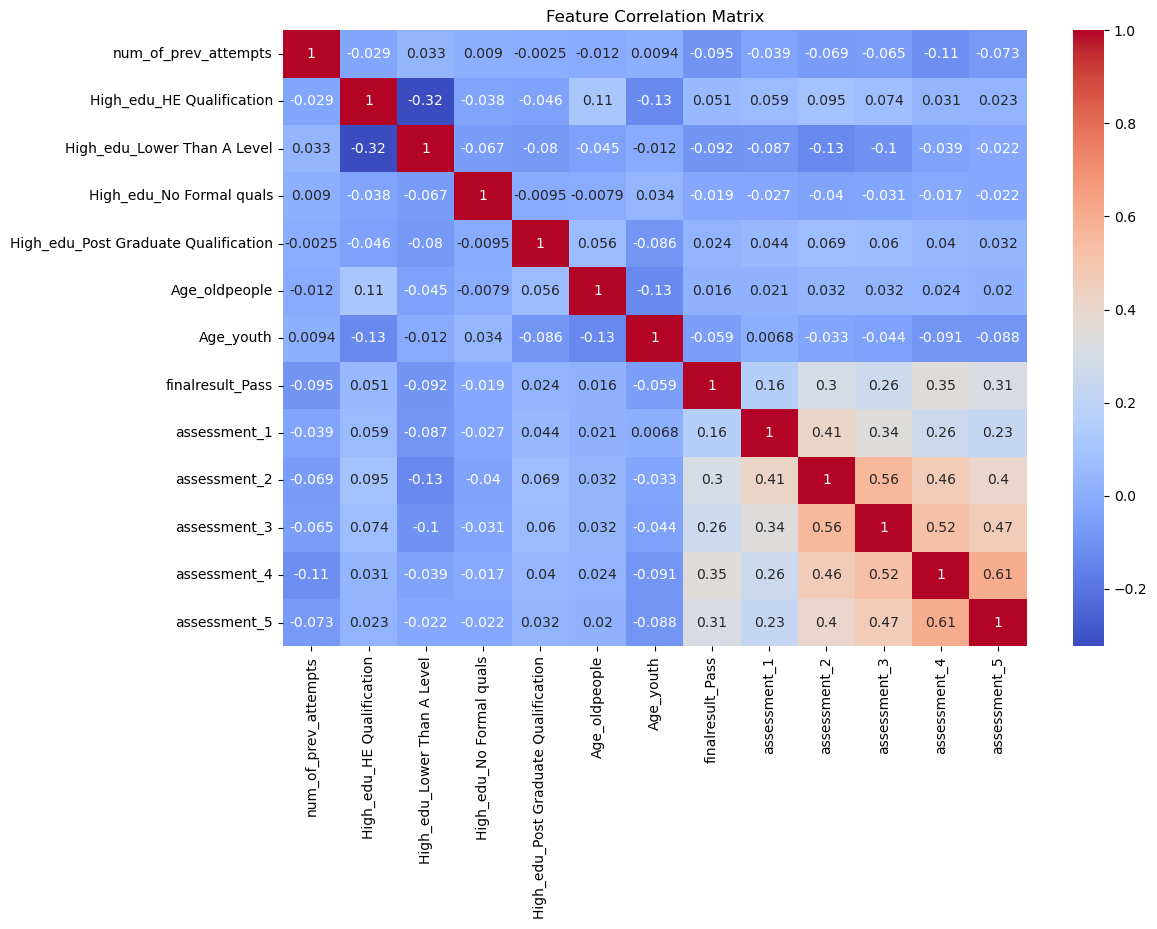

Targer Correlation with other Features sorted:
 finalresult_Pass                        1.000000
assessment_4                            0.350687
assessment_5                            0.312932
assessment_2                            0.302605
assessment_3                            0.260931
assessment_1                            0.162910
High_edu_HE Qualification               0.050706
High_edu_Post Graduate Qualification    0.023959
Age_oldpeople                           0.015679
High_edu_No Formal quals               -0.019232
Age_youth                              -0.059072
High_edu_Lower Than A Level            -0.091519
num_of_prev_attempts                   -0.095224
Name: finalresult_Pass, dtype: float64


In [139]:
corr_matrix = DatasetForProject.corr(method='pearson')  # 或使用'spearman'/'kendall'


plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


target_corr = corr_matrix['finalresult_Pass'].sort_values(ascending=False)
print("Targer Correlation with other Features sorted:\n", target_corr)

In [74]:
DatasetForProject

,num_of_prev_attempts,High_edu_HE Qualification,High_edu_Lower Than A Level,High_edu_No Formal quals,High_edu_Post Graduate Qualification,Age_oldpeople,Age_youth,finalresult_Pass,assessment_1,assessment_2,assessment_3,assessment_4,assessment_5
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.78,0.85,0.80,0.85,0.82
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.70,0.68,0.70,0.64,0.60
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.72,0.71,0.74,0.88,0.75
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.69,0.30,0.63,0.35,0.75
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.79,0.69,0.74,0.50,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32585,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.55,0.80,0.55,0.80,0.80
32587,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.80,0.85,0.75,1.00,1.00
32589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.80,0.81,0.72,1.00,0.80
32590,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.65,0.75,0.70,0.60,0.60


In [11]:
Assessments

,id_assessment,assessment_type,assessment_date,weight,courseID
0,1752,TMA,19.0,10.0,AAA2013J
1,1753,TMA,54.0,20.0,AAA2013J
2,1754,TMA,117.0,20.0,AAA2013J
3,1755,TMA,166.0,20.0,AAA2013J
4,1756,TMA,215.0,30.0,AAA2013J
...,...,...,...,...,...
201,37443,CMA,229.0,0.0,GGG2014J
202,37435,TMA,61.0,0.0,GGG2014J
203,37436,TMA,124.0,0.0,GGG2014J
204,37437,TMA,173.0,0.0,GGG2014J


In [12]:
StudentAssessment

,id_assessment,id_student,score
0,1752,11391,78.0
1,1752,28400,70.0
2,1752,31604,72.0
3,1752,32885,69.0
4,1752,38053,79.0
...,...,...,...
173907,37443,527538,60.0
173908,37443,534672,100.0
173909,37443,546286,80.0
173910,37443,546724,100.0


In [13]:
Courses

,module_presentation_length,courseID
0,268,AAA2013J
1,269,AAA2014J
2,268,BBB2013J
3,262,BBB2014J
4,240,BBB2013B
5,234,BBB2014B
6,269,CCC2014J
7,241,CCC2014B
8,261,DDD2013J
9,262,DDD2014J


In [31]:
StudentInfo

,courseID,id_student,num_of_prev_attempts,High_edu_HE Qualification,High_edu_Lower Than A Level,High_edu_No Formal quals,High_edu_Post Graduate Qualification,Age_oldpeople,Age_youth,finalresult_Pass,assessment_1,assessment_2,assessment_3,assessment_4,assessment_5
0,AAA2013J,11391,0,True,False,False,False,True,False,True,78.0,85.0,80.0,85.0,82.0
1,AAA2013J,28400,0,True,False,False,False,False,False,True,70.0,68.0,70.0,64.0,60.0
2,AAA2013J,30268,0,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>
3,AAA2013J,31604,0,False,False,False,False,False,False,True,72.0,71.0,74.0,88.0,75.0
4,AAA2013J,32885,0,False,True,False,False,False,True,True,69.0,30.0,63.0,35.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG2014J,2640965,0,False,True,False,False,False,True,False,<NA>,<NA>,<NA>,<NA>,<NA>
32589,GGG2014J,2645731,0,False,True,False,False,False,False,True,80.0,81.0,72.0,100.0,80.0
32590,GGG2014J,2648187,0,False,False,False,False,False,True,True,65.0,75.0,70.0,60.0,60.0
32591,GGG2014J,2679821,0,False,True,False,False,False,False,False,83.0,100.0,<NA>,<NA>,<NA>


In [15]:
StudentVle

,courseID,id_student,id_site,interact_date,sum_click
0,AAA2013J,11391,546614,-5,7
1,AAA2013J,11391,546614,0,10
2,AAA2013J,11391,546614,1,9
3,AAA2013J,11391,546614,2,3
4,AAA2013J,11391,546614,6,1
...,...,...,...,...,...
8459315,GGG2014J,2684003,897151,52,1
8459316,GGG2014J,2684003,897151,100,1
8459317,GGG2014J,2684003,897151,143,1
8459318,GGG2014J,2684003,897151,156,1


In [17]:
Assessments.to_sql('Assessments', engine, if_exists='replace', index=False)

-1

In [18]:
Courses.to_sql('Courses', engine, if_exists='replace', index=False)

-1

In [19]:
StudentAssessment.to_sql('StudentAssessment', engine, if_exists='replace', index=False)

-1

In [20]:
StudentInfo.to_sql('StudentInfo', engine, if_exists='replace', index=False)

-1

In [21]:
#StudentVle.to_sql('StuVle', engine, if_exists='replace', index=False)

In [136]:
def plot_training_history(history):
    plt.figure(figsize=(12,5))
    
    # 准确率曲线
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # 损失曲线
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


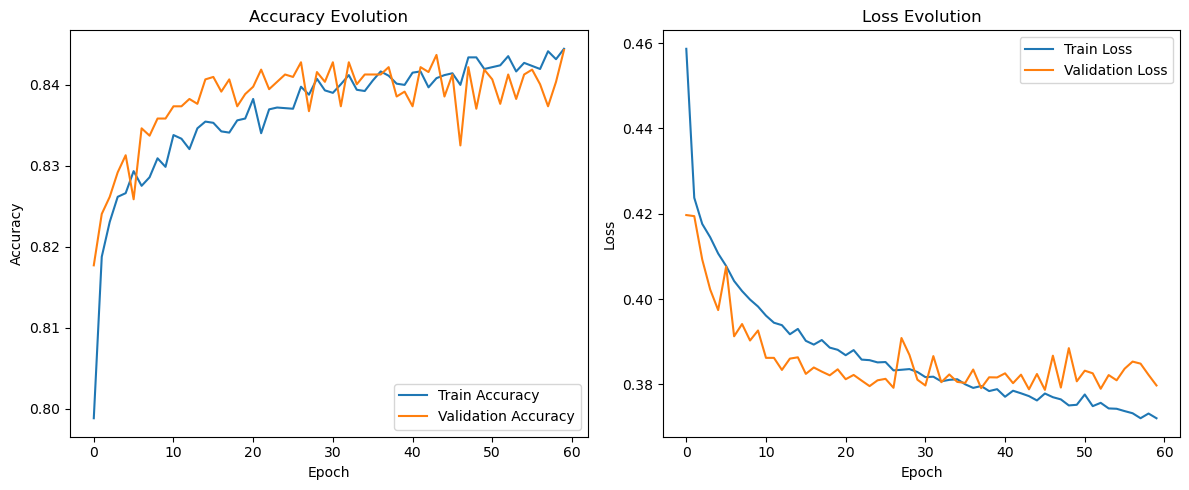

In [148]:
plot_training_history(history_base)

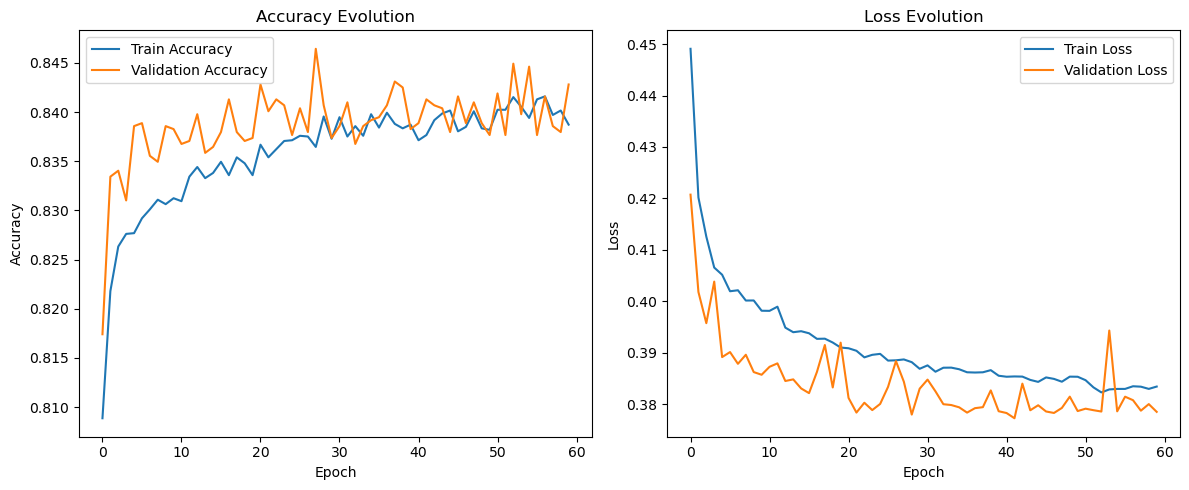

In [153]:
plot_training_history(history_s)

Feature importance weights: [0.7697493  0.7700558  0.84576964 1.0038803  0.9833237  0.8434437
 0.88593    1.0893484  1.1214061  1.3037409  1.0948203  1.1761439 ]


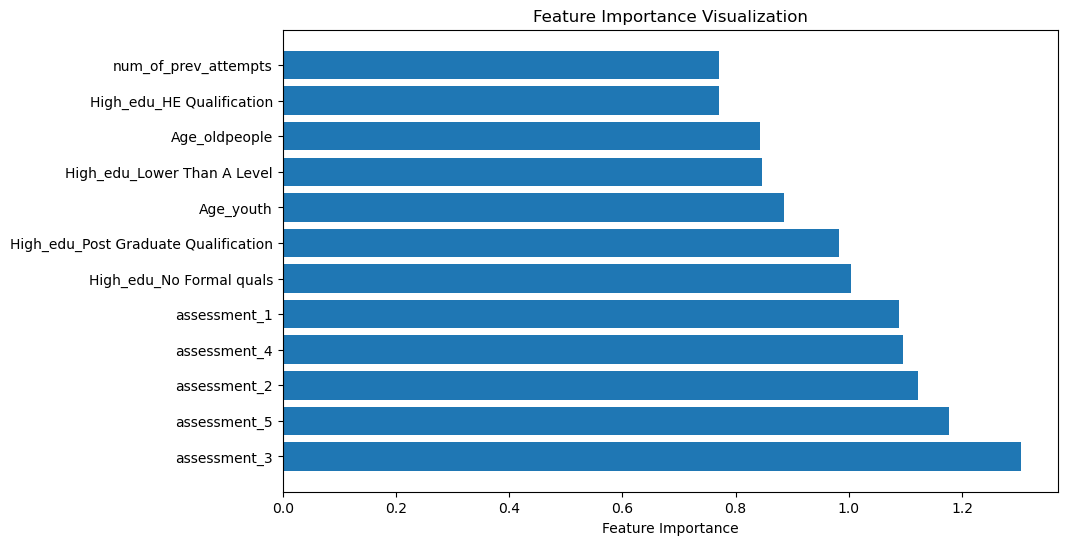

In [183]:
def plot_feature_importance(importance_weights, feature_names):
    import matplotlib.pyplot as plt
    import numpy as np
    
    indices = np.argsort(importance_weights)[::-1]
    sorted_importance = importance_weights[indices]
    sorted_features = np.array(feature_names)[indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_importance)), sorted_features)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Visualization')
    plt.show()


importance_layer = model_interpretability.get_layer(index=1)
importance_weights = importance_layer.get_importance_weights()
print("Feature importance weights:", importance_weights)

featureName = X_train.columns.tolist()

plot_feature_importance(importance_weights, [f"{featureName[i]}" for i in range(len(importance_weights))])

In [182]:
featureName = X_train.columns.tolist()
featureName

['num_of_prev_attempts',
 'High_edu_HE Qualification',
 'High_edu_Lower Than A Level',
 'High_edu_No Formal quals',
 'High_edu_Post Graduate Qualification',
 'Age_oldpeople',
 'Age_youth',
 'assessment_1',
 'assessment_2',
 'assessment_3',
 'assessment_4',
 'assessment_5']

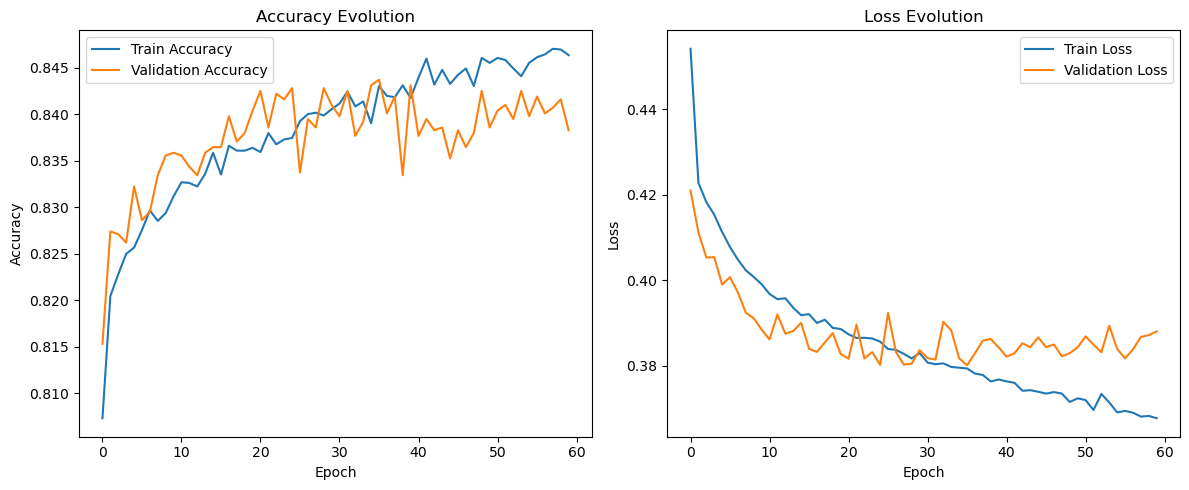

In [189]:
plot_training_history(history_interpretablitiy)

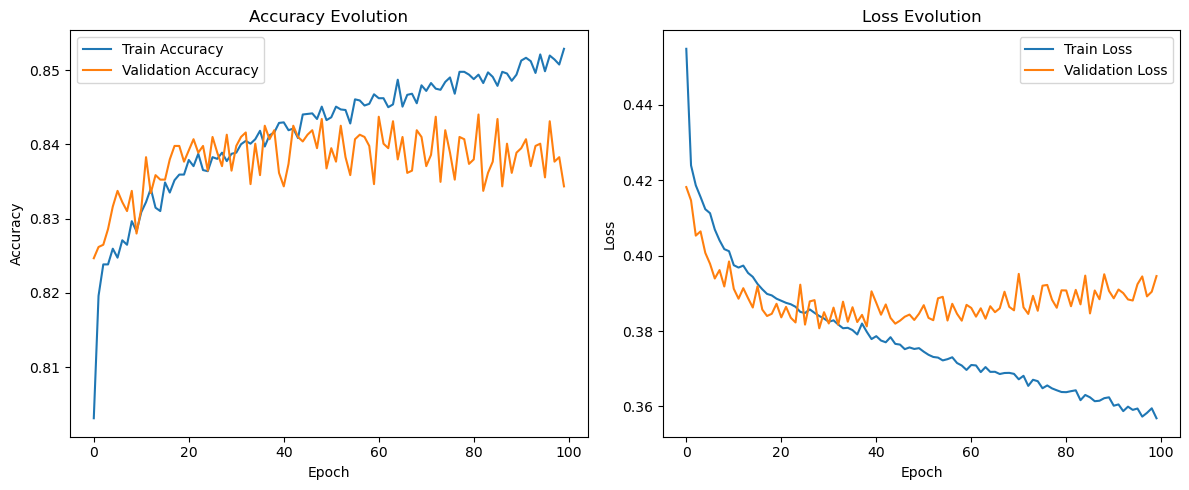

In [ ]:
history_base_100 = basemodel.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=64
)

plot_training_history(history_base_100)